# Mini Example for Elvis

### Import the module
Make the modules available for the Notebook

In [47]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

Import the ConfigBuilder and the simulate method

In [48]:
from elvis.config import ScenarioConfig
from elvis.simulate import simulate
from elvis.utility.elvis_general import create_time_steps

### Set up parameters for the simulation

#### Time parameters
* The start and end date are either of type datetime.datetime or as a str in format: '%y-%m-%d %H:%M:%S'.<br/><br/>
* The resolution (time in between two time steps) is either given as datetime.timedelta or as a str in format: '%H:%M:%S'<br/><br/>
* The time parameters are then put into a tuple in following order:<br/>
(start date, end date, resolution).

Time parameters fixate a Scenario to a timeline. This is necessary to be able to transform a stochastic ScenarioConfig into a specific simulatable ScenarioRealisation. They are needed to sample charging events because each charging event is bound to a specific arrival time.

In [49]:
import datetime

start_date = '2020-01-01 20:00:00' # format: '%y-%m-%d %H:%M:%S'
end_date = datetime.datetime(2020, 1, 7, 19, 0)
resolution = '01:0:0'
time_params = (start_date, end_date, resolution)

#### Charging Event parameters

Charging events have their own class in elvis: ChargingEvents. The ScenarioConfig can contain charging events taking away its stochasticity and limiting it to one realisation. If the stochasticity shall be preserved the ScenarioConfig instance stores the distributions (e.g. arrival or SOC) from which all realisations of this Scenario derive from. Therefore these distributions must be parameterised and stored in the ScenarioConfig instance.<br/>

##### Comment:
As of now when using an arrival distribution only weekly distributions are accepted. The arrival distribution starts at a Monday at 0:00.

In [50]:
num_charging_events = 5

arrival_distribution = [0 for x in range(168)] # create a list with 168 (hours of the week) entries (all 0)
arrival_distribution[8] = 1 # mondays at 8 o clock cars arrive
arrival_distribution[10] = 1 # modays at 10 o clock cars arrive



average_parking_time = 4
standard_deviation_parking_time = 1
mean_soc = 0.4
std_deviation_soc = 0.1



#### Vehicle Types

Each charging event has a vehicle type. This vehicle type contains the key parameters of the vehcile that describe its behaviour at the charging infrastructure. The required parameters are shown below.

In [51]:
# Vehicle types
min_power = 0
max_power = 150
capacity = 35.8
efficiency = 1
model = 'e-Golf'
brand = 'VW'
probability = 1

vehicle_types = [{'model': model, 'brand': brand, 'probability': probability, 
                 'battery': {'min_charge_power': min_power, 'max_charge_power': max_power, 'capacity': capacity, 'efficiency': efficiency}}]

In order to simulate the dependency between SOC and max power of the vehicle two further optional parameters are introduced:
* start_power_degradation (0 <= x <= 1)
* max_degradation_level (0 <= x <= 1)

Typically the batteries can not be charged with their rated current towards the end of a charging cycle in order to keep the voltage within limits. Therefore the current and with that the power is decreased. In Elvis only a linear relation can be modelled.
To do so the start_power_degredation parameter configures the SOC-level at which the power degredation starts and the max_degredation_level configures the fraction of the configured max_power of the vehicle type to which the power finally degrades to when SOC=1 is reached.

In [52]:
# Vehicle type with degredation
min_power = 0
max_power = 150
capacity = 35.8
efficiency = 1
model = 'e-Golf'
brand = 'VW'
probability = 1
start_power_degradation = 0.8
max_degradation_level = 0.35

vehicle_types = {'model': model, 'brand': brand, 'probability': probability, 
                 'battery': {'min_charge_power': min_power, 'max_charge_power': max_power, 
                             'capacity': capacity, 'efficiency': efficiency},
                 'start_power_degradation': start_power_degradation, 'max_degradation_level': max_degradation_level}

#### Infrastructure Design
##### Manually generating infrastructure (completely custombisable)
The infrastructure design is assumed to be a tree it is passed as a nested dict structure. <br/>
Nodes in the tree structure are described as a dict with the following keys:
* id: str (not necessary anymore)
* max_power: float/int (maximal power that is allowed to pass that node)
* min_power: float/int (minimal power that must go through the node if the power is not 0)
* children*: list (containing dicts for each child of the previous node, excluded in charging point dicts)

There are three types of nodes in the tree structure: transformers, charging stations and charging points. Children of
a transformer always are charging stations. Children of charging stations always are charging points. The infrastructure design always starts with a dict for the transformer.


*The children key is always named after the node type of its children. For a transformer: charging stations, for a charging_station: charging points. Charging point dicts do not contain a children key.

In [53]:
infrastructure = {'transformers': [{'id': 'transformer1', 'max_power': 100, 'min_power': 10, 'charging_stations': [{'id': 'cs1', 'max_power': 10, 'min_power': 1, 'charging_points': [{'id': 'cp1', 'max_power': 5, 'min_power': 0.5}, {'id': 'cp2', 'max_power': 5, 'min_power': 0.5}]}, {'id': 'cs2', 'max_power': 10, 'min_power': 1, 'charging_points': [{'id': 'cp3', 'max_power': 5, 'min_power': 0.5}, {'id': 'cp4', 'max_power': 5, 'min_power': 0.5}]}]}]}


##### Wallbox infrastructure

To initialise a symmetric wallbox infrastructure with following characteristics a prebuild function can be used:

* Same amount of charging points per charging station for all charging stations
* Same power limits (min and max) between the same type of node (charging point/station)
* Only one transformer


function parameters
def wallbox_infrastructure(num_cp, power_cp, 
                           num_cp_per_cs=1, power_cs=None, power_transformer=None, 
                           min_power_cp=0, min_power_cs=0, min_power_transformer=0):

###### Required:
* num_cp: (int): Number of charging points.
* power_cp: (int or float): Max power per charging point.

###### Optional:
* num_cp_per_cs: (int) Number of charging points per charging station. Default: 1
* power_cs: (int or float): Max power of the charging station. Default: power_cp * num_cp_per_cs
* power_transformer: (int or float): Max power of the transformer. Default: num_cs * num_cp_per_cs * power_cp
* min_power_cp: (int or float): Minimum power (if not 0) for the charging point. Default: 0
* min_power_cs: (int or float): Minimum power (if not 0) for the charging station. Default: 0
* min_power_transformer: (int or float) : Minimum power (if not 0) for the charging station. Default: 0

In [54]:
from elvis.set_up_infrastructure import wallbox_infrastructure

infrastructure_wallbox = wallbox_infrastructure(4, 3.7, num_cp_per_cs=2)
infrastructure_wallbox

{'transformers': [{'charging_stations': [{'min_power': 0,
     'max_power': 7.4,
     'charging_points': [{'min_power': 0, 'max_power': 3.7, 'id': 'cp1'},
      {'min_power': 0, 'max_power': 3.7, 'id': 'cp2'}],
     'id': 'cs1'},
    {'min_power': 0,
     'max_power': 7.4,
     'charging_points': [{'min_power': 0, 'max_power': 3.7, 'id': 'cp3'},
      {'min_power': 0, 'max_power': 3.7, 'id': 'cp4'}],
     'id': 'cs2'}],
   'id': 'transformer1',
   'min_power': 0,
   'max_power': 14.8}]}

#### Integrating a storage

In [55]:
# Start by copying wallbox infrastructure as base
infrastructure_storage = infrastructure_wallbox
# Initialise storage dict
storage = {'capacity': 100, 'max_power': 50, 'min_power': 0}
# Add storage to transformer dict
infrastructure_storage['transformers'][0]['storage'] = storage

#### Other parameters
* queue_length: Maximal number of cars that wait at the infrastructure if no charging point is available. The connect to a charging point if one becomes available before their leaving time is reached.
* disconnect_by_time: Decision variable when to disconnect a car from a charging point. <br/>
True: The cars disconnect once their leaving time is reached in total disregard of the current SOC. As a result the charging point might be blocked even though the car is fully charged.<br/>
False: The cars disconnect when their SOC target is reached or their leaving time is reached whatever comes first.
* scheduling_policy: The policy that assigns the power to the cars. Can be passed as a str (UC, FCFS, DF, OPT) or as an instance of the schduling policy classes (see sched/schedulers.py).

##### Scheduling policies
* UC - Uncontrolled: Node power limits are not checked. Each car is charging with max power only depending on vehicle and charging point limits. Charging station and transformer limits are expected to be exceeded.
* FCFS - First Come First Served: Power on nodes are kept within limits. Power assignment is prioritised by vehicle arrival time.
* DF - Discrimination Free: Power on nodes are kept within limits. Power assignment is not prioritised but spreaded equally between all connected vehicles. Implementation note: To reduce complexity vehicles are charged in turns with parameterised length (config.df_charging_period). In case only one car can be charged but two are connected first car 1 is charged with max power for the length of df_charging_period followed by car 2. This will be the order even though both cars could be charged with half the power at the same time.

In [56]:
queue_length = 2 # optional as per default: 0
disconnect_by_time = True # as per default: True
scheduling_policy = 'FCFS' # only UC, DF and FCFS are implemented
transformer_preload = [0] * 10000 # not implemented fully -> if more than 10k simulation steps adjust len of list
opening_hours = None # Default: None. To set times pass tuple: (opening_hour, closing_hour). Connected vehicles will be disconected at closing hour. New vehicles can only be connected in between opening hours.

#### Not implemented

In [57]:
emissions_scenario = None
renewables_scenario = None


### Assign values to the ScenarioConfig

The with_VARIABLE-NAME methods are used to assign either new values to a ConfigBuilder or to change values from a previous simulation run.<br/>

A realisation is a simulatable configuration without stochasticity. So from all distributions samples were drawn.

In [58]:
config = ScenarioConfig()

config.with_arrival_distribution(arrival_distribution)
# Methods can be chained
config.with_queue_length(queue_length).with_scheduling_policy(scheduling_policy).with_disconnect_by_time(disconnect_by_time).with_num_charging_events(num_charging_events)

config.with_mean_park(average_parking_time)
config.with_std_deviation_park(standard_deviation_parking_time)
config.with_mean_soc(mean_soc)
config.with_std_deviation_soc(std_deviation_soc)
config.with_vehicle_types(**vehicle_types)

config.with_infrastructure(infrastructure)

config.with_transformer_preload(transformer_preload)

# create realisation given a start and an end date and as a resolution
realisation = config.create_realisation(start_date, end_date, resolution)

In [59]:
realisation.charging_events

### Load an existing ConfigBuilder

ConfigBuilder instances can be saved and reloaded. They are stored in data/config_builder/.

To read in a yaml file the builder class method from_yaml can be called by passing the yaml string. The data of the yaml string is then assigned to the fields of the builder instance.

TODO: As of now all necessary fields must be in the yaml file. It should only read the existing ones and check when build() is called whether everything necessary is there. Or maybe when simulate() is called.

In [60]:
import yaml

yaml_file_path = r'../data/config_builder/kundenparkplatz.yaml'
with open(yaml_file_path, 'r') as file:
    yaml_str = yaml.full_load(file)

config_from_yaml = ScenarioConfig.from_yaml(yaml_str)
print(config_from_yaml)

realisation_from_yaml = config_from_yaml.create_realisation(start_date, end_date, resolution)

Vehicle types: <generator object ScenarioConfig.__str__.<locals>.<genexpr> at 0x13b8fcd40>Mean parking time: 4
Std deviation of parking time: 0.5
Mean value of the SOC distribution: 0.6
Std deviation of the SOC distribution: 0.2
Max parking time: 24
Number of charging events per week: 500
Vehicles are disconnected only depending on their parking time
Queue length: 0
Opening hours: None
Scheduling policy: Uncontrolled



### Simulate

The simulate method receives a config and performs the simulation. It returns an instance of class ElvisResult containing the results of the simulation.

In [61]:
results = simulate(realisation)

Progress: 1.0 %
Progress: 6.0 %
Progress: 10.0 %
Progress: 15.0 %
Progress: 20.0 %
Progress: 25.0 %
Progress: 30.0 %
Progress: 35.0 %
Progress: 40.0 %
Progress: 44.0 %
Progress: 49.0 %
Progress: 54.0 %
Progress: 59.0 %
Progress: 64.0 %
Progress: 69.0 %
Progress: 74.0 %
Progress: 78.0 %
Progress: 83.0 %
Progress: 88.0 %
Progress: 93.0 %
Progress: 98.0 %


### Create a load profile from Result

The power assigned to each charging point is stored in the field power_charging_points. It is of type dict with the IDs of the charging points as keys and dicts containing floats of the assigned powers of those charging points with integers as keys representing the simulation step. This allows already though to create a load profile.

<Axes: xlabel='date'>

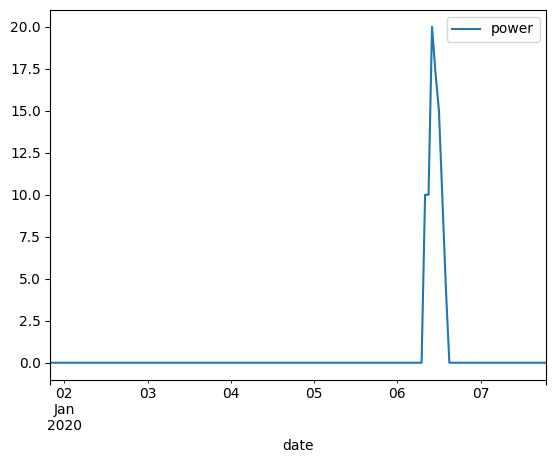

In [62]:
import pandas as pd
from elvis.utility.elvis_general import num_time_steps

start = realisation.start_date
end = realisation.end_date
res = realisation.resolution
load_profile = results.aggregate_load_profile(num_time_steps(start, end, res))
df = pd.DataFrame(zip(create_time_steps(start, end, res), load_profile))

df.rename(columns={0: 'date', 1: 'power'}, inplace=True)
df.set_index('date', inplace=True)

df.plot()

In [63]:
realisation.resolution

datetime.timedelta(seconds=3600)

#### Calcluating KPIs

#### Max simultaneity
Max occuring power / Max possible power <br/>
Max possible power in this case is the sum over all charging point limits. Note that this limit may never be reached since the power can not only be limited by the charging points but the transformer or the charging stations aswell.

In [64]:
results.simultaneity_factor(config.infrastructure)

1.0

Or with results.config being set.

In [65]:
results.scenario = realisation
results.simultaneity_factor()

1.0

#### Further KPIs

In [66]:
print('Total energy charged across all charging points in kWh: ' + str(results.total_energy_charged(resolution=datetime.timedelta(minutes=15))) + '\n')
print('Highest load of all charging points in kW: ' + str(results.max_load()) + '\n')
print('Average charging time (not parking time) in minutes: ' + str(int(results.average_charging_time().total_seconds()/60)) + '\n')

Total energy charged across all charging points in kWh: 21.61875

Highest load of all charging points in kW: 20.0

Average charging time (not parking time) in minutes: 156



#### Electricity Costs
##### Fixed costs
Meaning same price independent of the hour of consumption

Electricity rates are expected to be in €/kWh

In [69]:
results.electricity_costs_fix(electricity_rate=0.4)

TypeError: ElvisResult.total_energy_charged() missing 1 required positional argument: 'resolution'

##### Variable costs
Electricity price depends on the hour of the day

In [70]:
import random
# List containing the prices for each hour of the day
var_rate = [random.random() for x in range(24)]
results.electricity_costs_24_variable(variable_electricity_rate=var_rate)

40.05723149247707